In [1]:
from lumberjack_tools import *
from lumberjack_trading  import *

Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1
TaLib version  0.4.19
FinTA version  1.3
Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1


## PARAMETRES

In [2]:
x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2018-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 555555555555555
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.002
_sl = 0.001
_exposure = 1
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0

## Chargement de la base, K-Lines, Application de stratégie (=> Signal)

In [3]:
df = joblib.load('BASES/EURUSD_m5')

In [4]:
%%time
for _col in df.columns:
    if df[_col].dtypes == 'float64':
        df[_col] = df[_col].astype(np.float32)

CPU times: user 736 ms, sys: 286 ms, total: 1.02 s
Wall time: 1.02 s


In [5]:
%%time
def strategy(df):
    df1 = joblib.load('BASES/closedPositions.dag')
    df1['executionDate'] = pd.to_datetime(df1.executionDate)
    df1.rename(columns={'executionDate':'DateIndex'},inplace=True)
    df['DateIndex'] = pd.to_datetime(df.index)
    df1.index = df1.DateIndex
    df1['Signal'] = np.where(df1.action=='short',-1,np.where(df1.action=='long',1,0))
    df_neg = df1[df1.Signal==-1][['Signal']]
    df_pos = df1[df1.Signal==1][['Signal']]
    POS = df_pos.index.to_list()
    NEG = df_neg.index.to_list()
    df['Signal'] = np.where(df.index.isin(POS),1,np.where(df.index.isin(NEG),-1,0))
    return df

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [6]:
df = strategy(df)

In [7]:
%%time
df.Signal.value_counts()

CPU times: user 5.52 ms, sys: 1.55 ms, total: 7.07 ms
Wall time: 5.81 ms


 0    811202
-1      5220
 1      4485
Name: Signal, dtype: int64

In [8]:
joblib.dump(df,'BASES/df_raw_prep')

['BASES/df_raw_prep']

In [9]:
df = joblib.load('BASES/df_raw_prep')

In [10]:
df = df.dropna()

In [11]:
%%time

df = klines(df)
print(df.Signal.value_counts())

 0    706356
-1      4553
 1      3936
Name: Signal, dtype: int64
CPU times: user 45.8 ms, sys: 12.4 ms, total: 58.2 ms
Wall time: 40.1 ms


## Purification du signal sur train + test (de _strat à _stop)

In [12]:
%%time
_nb_looser = 10000000000
TRACKER = []
_year_bottom = _start
_year_top = _stop
_verbose = 0

print()
print(col.Fore.CYAN,'TRAIN/TEST WITHOUT AI',col.Style.RESET_ALL)


TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)


print()
print(col.Fore.BLUE,'DENOISING & ENHANCING',col.Style.RESET_ALL)
while _nb_looser > 0 :
    
    df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
    df['Valid'] = np.where(((df.Signal!=0)&(df.TRACKER==1)),1,0)
    df['Signal'] = np.where(((df.Valid==1)&(df.Signal==1)),1,np.where(((df.Valid==1)&(df.Signal==-1)),-1,0))
    ##### Purification of signal by denoising and enhancing
    TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print('Shape de features',df.shape)
joblib.dump(df,'BASES/df_denoz_EURUSD_m5')
joblib.dump(TRACKER,'BASES/TRACKER')



 TRAIN/TEST WITHOUT AI 
Début des opérations horodatée à 2021-05-31 10:42:20.682656
_trigger_rsi : 0
100%|██████████| 546188/546188 [00:24<00:00, 22324.58it/s]
BT's execution time 0:00:31.316184
 Total Number of trades 4238 
 PROFIT FACTOR :  0.72 
 Winners Ratio : 28.06 % 
_bt_report : 0

 DENOISING & ENHANCING 
Début des opérations horodatée à 2021-05-31 10:42:55.377781
_trigger_rsi : 0
100%|██████████| 546188/546188 [00:17<00:00, 30386.58it/s]
BT's execution time 0:00:24.755476
 Total Number of trades 1189 
 PROFIT FACTOR :  inf 
 Winners Ratio : 100.0 % 
_bt_report : 0
Shape de features (714845, 70)
CPU times: user 43.5 s, sys: 1.02 s, total: 44.6 s
Wall time: 1min 3s


['BASES/TRACKER']

## CHargement de la base débruitée

In [19]:
df = joblib.load('BASES/df_denoz_EURUSD_m5')
df.Signal.value_counts()

 0    713656
-1       607
 1       582
Name: Signal, dtype: int64

## Features Transformation

In [17]:
%%time
#df = df[['Open','High','Low','Close','Body','UpperShadow','LowerShadow','Color','Valid','TRACKER','Signal']]
df = exotic_indicators(df)
df.shape

CPU times: user 19.7 s, sys: 193 ms, total: 19.9 s
Wall time: 19.7 s


(714845, 87)

In [18]:
%%time
# Colonnes non traitées
COLUMNS = ['Valid','TRACKER','Signal','DateIndex','Symbol','Date']

# différences sur 1, 2, 3, 4 et 5 bougies
_factor = 12
df = feature_diff(df,COLUMNS,_factor)

df.shape

CPU times: user 16 s, sys: 10.9 s, total: 26.9 s
Wall time: 24.7 s


(713809, 989)

In [8]:
joblib.dump(df,'BASES/df_inter_EURUSD_m5')

['BASES/df_inter_EURUSD_m5']

In [3]:
df = joblib.load('BASES/df_inter_EURUSD_m5')
TRACKER = joblib.load('BASES/TRACKER')

In [24]:
%%time
COLUMNS = ['Valid','TRACKER','Signal','DateIndex','Symbol','Date']
# Transformation par les inverse, carré, cos, sin, log et tan
df = feature_transformation(df,COLUMNS)

df.shape

## Préparation de df et sauvgarde de df_raw

In [4]:
%%time

# On récupère les dates des bons signaux, et on assigne 1 si le signal était gagnant
df['Valid'] = np.where(df.index.isin(TRACKER),1,0)

# On réapplique Strategy pour ré-avoir tous les signaux gagnants et non gagnants
df = strategy(df)

# On met de côté cette dataframe avec df_raw
df_raw = df.copy()

# On réduit la base à une base n'ayant que des signaux gagnants et non gagnants (issus de Strategy)
df = df[df.Signal!=0]

# Si on a un Signal à 1 ou -1 et que c'était un signal gagnant, on met Valid à 1, sinon à 2
_condition1 = ((df.Signal != 0) & (df.Valid == 1))
_condition2 = ((df.Signal != 0 )& (df.Valid == 0))
df['Valid'] = np.where(_condition1,1,np.where(_condition2,2,0))

# Répartition de la classe Valid
print(df.Valid.value_counts())

# Sauvegarde de df en df_prep et de df_raw
joblib.dump(df,'BASES/df_prep_EURUSD_m5')
joblib.dump(df_raw,'BASES/df_raw_EURUSD_m5')


2    31833
1       66
Name: Valid, dtype: int64
CPU times: user 3.89 s, sys: 4.27 s, total: 8.16 s
Wall time: 8.55 s


['BASES/df_raw_EURUSD_m5']

## Début Base déjà préparée

In [5]:
%%time
df = joblib.load('BASES/df_prep_EURUSD_m5')
df_raw = joblib.load('BASES/df_raw_EURUSD_m5')
df.shape

CPU times: user 1.83 s, sys: 2.6 s, total: 4.43 s
Wall time: 4.43 s


(31899, 974)

## Split des jeux d'entrainement et mise à l'échelle

In [6]:
%%time
# Séparation en jeux d'entrainement, de test et séparation du jeu out of sample
df_train, df_test, df_oos = split_df(df,_start,_mid,_stop,_last)

# Colonnes mises en exception pour le passage à l'échelle
EXCEPTION = ['Signal', 'Color', 'Valid','TRACKER']

# Choix du scaler
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MaxAbsScaler()


# Mise à l'échelle
df = feature_scaling(df,scaler,EXCEPTION)

# Sauvegarde des jeux de données
joblib.dump(df_train,'BASES/train_EURUSD_m5')
joblib.dump(df_test,'BASES/test_EURUSD_m5')
joblib.dump(df_oos,'BASES/oos_EURUSD_m5')

CPU times: user 851 ms, sys: 165 ms, total: 1.02 s
Wall time: 1.03 s


['BASES/oos_EURUSD_m5']

## Début avec jeu de données séparées

In [7]:
%%time
df_train = joblib.load('BASES/train_EURUSD_m5')
df_test = joblib.load('BASES/test_EURUSD_m5') 
df_oos = joblib.load('BASES/oos_EURUSD_m5') 

CPU times: user 59.7 ms, sys: 63.2 ms, total: 123 ms
Wall time: 122 ms


In [8]:
%%time
# Remplacement des 2 de Valid par un 0
df_train['Valid'] = np.where(df_train.Valid==2,0,1)#df_train.Valid)#.reshape(-1,1)
df_test['Valid'] = np.where(df_test.Valid==2,0,1)#df_test.Valid)#.reshape(-1,1)
print(df_train.Valid.value_counts())

# Undesmapling
#df_train = undersample2(df_train,'Valid')

# Oversampling
#df_train = oversample2(df_train,'Valid')

# Séparation des X et des y
y_train = df_train.Valid
y_test = df_test.Valid
X_train = df_train.drop(['Valid','Signal','TRACKER'],axis=1)
X_test = df_test.drop(['Valid','Signal','TRACKER'],axis=1)


0    15420
1       50
Name: Valid, dtype: int64
CPU times: user 24.7 ms, sys: 1.85 ms, total: 26.6 ms
Wall time: 25 ms


## Feature Selection

R2_Score :  -0.0670273815568283
Mean Absolute Error 0.0050388516465742
ok
CPU times: user 2.62 s, sys: 55.2 ms, total: 2.67 s
Wall time: 2.68 s


((15470, 15), (8309, 15))

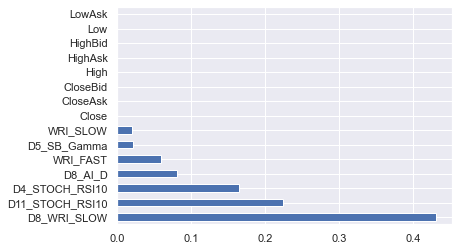

In [9]:
%%time
# Si selection en Univariate
#X_train, X_test = univariate_feature_selection(X_train, X_test, y_train, _k=6,_send=0)

# Si Selection par lasso
#lasso_feature_selection(X_train,X_test,y_train,y_test,_send=0)

# RF Method
X_train, X_test = rf_feature_selection(X_train,X_test,y_train,y_test,n=15,_send=1)

# Si selection par l1
#X_train, X_test = l1_feature_selection(X_train, X_test, y_train, _C=1,_send=0)

joblib.dump(X_train,'BASES/X_train.dag')
joblib.dump(X_test,'BASES/X_test.dag')

# Vérification des shapes
X_train.shape, X_test.shape

In [17]:
X_train = X_train[['D8_WRI_SLOW']]#,'D11_STOCH_RSI10','D4_STOCH_RSI10','D8_AI_D','WRI_FAST','D5_SB_Gamma','WRI_SLOW']]
X_test = X_test[['D8_WRI_SLOW']]#,'D11_STOCH_RSI10','D4_STOCH_RSI10','D8_AI_D','WRI_FAST','D5_SB_Gamma','WRI_SLOW']]

# CHARGEMENT XTRAIN ET XTEST L1
X_train = joblib.load('BASES/X_train.dag')
X_test = joblib.load('BASES/X_test.dag')

## Entrainement

In [18]:
%%time
# Affectatioon de poids différents en fonction des clases
class_weight = affect_weight(y_train)
BATCH_SIZE = 320
# Construction du modèle
_first_a = 'relu'
_a='relu'
_last_a='sigmoid'
model = make_model(X_train, _first_a, _a, _last_a, BATCH_SIZE)

# Compilation du modèlé
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, min_delta=0.001, restore_best_weights=True,) # (monitor='val_prc', verbose=1, patience=20, mode='max', restore_best_weights=True)

METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = compile_model(model,METRICS=METRICS)



Initial bias [5.73139764]

Weight for class 0: 154.70
Weight for class 1: 0.50
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 63)                126       
_________________________________________________________________
dropout_9 (Dropout)          (None, 63)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8192      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________

## Evaluation du meilleur Batch

In [19]:
%%time
# Evaluation du meilleur batch
_borne = int(X_train.shape[0])
_step = 100
BATCH_SIZE = evaluate_batch(model, X_train, y_train,_borne,_step)

100%|██████████| 155/155 [00:08<00:00, 17.67it/s]Meilleur Loss: 0.7167
Meilleur Batch: 7010.0000
CPU times: user 28.1 s, sys: 5.24 s, total: 33.4 s
Wall time: 8.77 s



## Fit the model

Batch retenu 7010
Train on 15470 samples, validate on 8309 samples
Epoch 1/20
15470/15470 [==============================] - 1s 89us/sample - loss: 0.2682 - accuracy: 0.9704 - precision: 0.0049 - recall: 0.0400 - auc: 0.5554 - prc: 0.0040 - val_loss: 0.0354 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0019
Epoch 2/20
15470/15470 [==============================] - 1s 67us/sample - loss: 0.0945 - accuracy: 0.9946 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4610 - prc: 0.0028 - val_loss: 0.0164 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4974 - val_prc: 0.0018
Epoch 3/20
15470/15470 [==============================] - 1s 67us/sample - loss: 0.0755 - accuracy: 0.9959 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4737 - prc: 0.0030 - val_loss: 0.0213 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4378 - val_prc: 0.0016
Epoch 4/

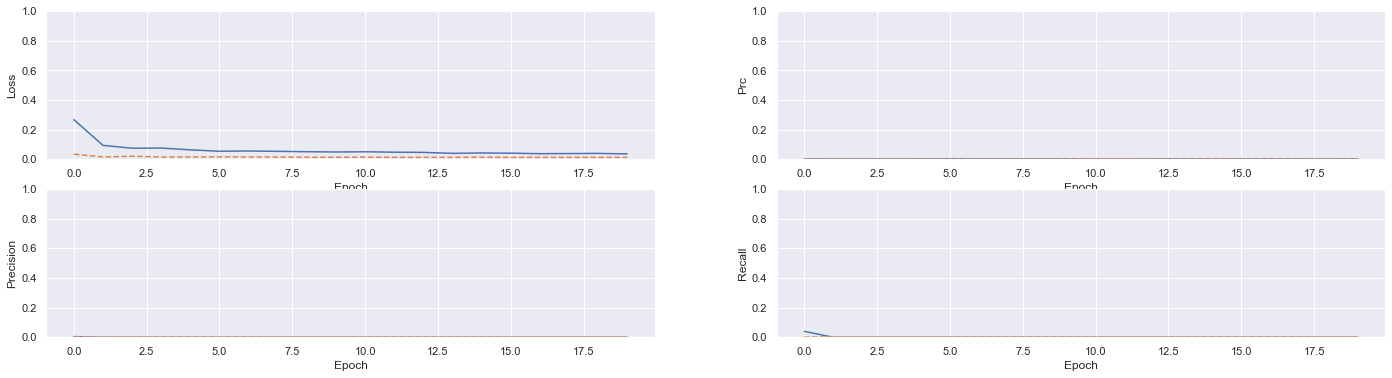

In [20]:

epochs=20
#BATCH_SIZE = 320
print('Batch retenu',BATCH_SIZE)
history = fit_model(X_train,y_train,X_test,y_test,model,epochs=epochs,callbacks=None,class_weight=class_weight)

## Predictions de yhat et attribution des étiquettes

In [21]:
%%time
ytest, yhat = norm_target(model,X_test,y_test)

100%|██████████| 8309/8309 [00:00<00:00, 267919.80it/s]CPU times: user 666 ms, sys: 156 ms, total: 821 ms
Wall time: 505 ms



## Obtention des résultats du training

Signaux - Accuracy : 52.49 %
Signaux - Precision : 0.25 %
Signaux - Recall : 62.5 %
Achat - F-measure: : 0.5 %


              precision    recall  f1-score   support

           0       1.00      0.52      0.69      8293
           1       0.00      0.62      0.01        16

    accuracy                           0.52      8309
   macro avg       0.50      0.57      0.35      8309
weighted avg       1.00      0.52      0.69      8309

         Positifs Négatifs
Positifs       10        6
Négatifs     3942     4351

Vrais signaux positifs trouvés    :  10
Vrais signaux positifs non trouvé : 6
Total des signaux posistifs : 16
 Précision : 0.25 % 
 Recall 62.5 % 
 F-Score : 0.5 % 


Vrais signaux négatifs trouvés    :  4351
Vrais signaux négatifs non trouvé : 3942
Total des signaux négatifs : 8293
 Précision : 99.86 % 
 Recall 52.47 % 
 F-Score 68.79 % 


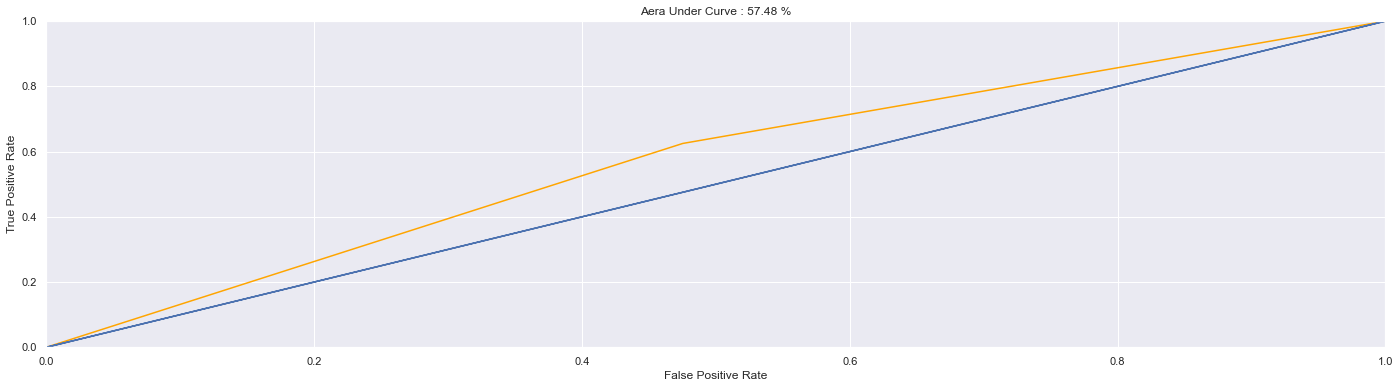

In [22]:
get_results(y_test,yhat)

## Sauvegarde du model

In [20]:
model.save('MODELS/Essais')

INFO:tensorflow:Assets written to: MODELS/Essais/assets


In [21]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (26, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  
  lims = [
      np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
      np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
  ]

  # now plot both limits against eachother
  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims)

plot_roc("Train", y_train, train_predictions_weighted, color=colors[0])
plot_roc("Test", y_test, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

NameError: name 'train_predictions_weighted' is not defined

## Test on OOS

In [23]:
%%time
# Colonnes non traitées
COLUMNS = ['Valid','TRACKER','Signal']

# Colonnes mises en exception pour le passage à l'échelle
EXCEPTION = ['Signal', 'Color', 'Valid','TRACKER']

df_raw = joblib.load('BASES/df_raw_EURUSD_m5')
df_raw = strategy(df_raw)

_, _, oos = split_df(df_raw.drop(['Valid','TRACKER','Signal'],axis=1),_start, _mid, _stop, _last)
oos = strategy(oos)
oos = oos.dropna()

# Chargement des indicateurs exotiques
oos = exotic_indicators(oos)

# différences sur 1, 2, 3, 4 et 5 bougies
oos = feature_diff(oos,COLUMNS)

# Transformation par les inverse, carré, cos, sin, log et tan
oos = feature_transformation(oos,COLUMNS)


# Choix du scaler()
#scaler = MinMaxScaler()
#scaler = StandardScaler()
#scaler = Normalizer()
scaler = MaxAbsScaler()
#scaler = MinMaxScaler()

# Mise à l'échelle
oos = feature_scaling(oos,scaler,EXCEPTION)

# Séparation des X et des y
X_oos = oos.copy()

colfilter = X_test.columns.to_list()
colfilter.append('Signal')

X_oos1 = X_oos[colfilter].copy()

In [ ]:
%%time
X_oos = X_oos1.copy()
X_oos['Valid'] = model.predict(X_oos.drop(['Signal'],axis=1))

_condition0 = X_oos.Valid <= 0.5

X_oos['Valid'] = np.where(_condition0,0,1)

_condition1 = ((X_oos.Signal == 1) & (X_oos.Valid == 1))
_condition2 = ((X_oos.Signal == -1) & (X_oos.Valid == 1))

X_oos['FinalSignal'] = np.where(_condition1,1,np.where(_condition2,-1,0))

_, _, df_oos = split_df(df_raw,_start, _mid, _stop, _last)

df_oos['Signal'] = X_oos.FinalSignal


In [ ]:
%%time
_year_bottom = df_oos.index[0]
_year_top = df_oos.index[-1]
_verbose = 1
_,_ = bt(df_oos,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)